In [1]:
# Testing use case https://arxiv.org/pdf/2012.09816.pdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from tensorflow.keras.datasets import mnist
import keras

# Generate the train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
 
# Generate some noisy data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [2]:
import tensorflow as tf
import numpy as np

def weights_diff(model1, model2):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > 0.01:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
            + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
      print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)

        
def weights_diff_stats(model1, model2):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    res = []
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > 0.01:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      res.append(percentage_diff)
#       print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
#             + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
#       print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)
    return res

def epoch_weight_diff(m1_prefix, m2_prefix):
    res = []
    for i in range(1, 61):
        t = '{}-{}'.format(m1_prefix, str(i).zfill(2))
        s = '{}-{}'.format(m2_prefix, str(i).zfill(2))

        m1 = tf.keras.models.load_model(t)
        m2 = tf.keras.models.load_model(s)

        stats = weights_diff_stats(m1, m2)
        res.append(stats)
    
    lines = []
    for j in range(len(res[0])):
        line = []
        for i in range(len(res)):
            line.append(res[i][j])
        lines.append(line)
    return lines

In [3]:
m1 = tf.keras.models.load_model('redundancy_check/v0/teacher_old_60')
m2 = tf.keras.models.load_model('redundancy_check/v0/student_old_60')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 297 / 324 (91.66666666666666%)
Maximum Difference in Layer 1: 0.51335806
Amount of different weights in Layer 2: 11254 / 11664 (96.4849108367627%)
Maximum Difference in Layer 2: 1.1523159
Amount of different weights in Layer 3: 11279 / 11664 (96.69924554183812%)
Maximum Difference in Layer 3: 1.2177842
Amount of different weights in Layer 4: 11288 / 11664 (96.7764060356653%)
Maximum Difference in Layer 4: 0.91574544
Amount of different weights in Layer 5: 873658 / 903168 (96.73261231575964%)
Maximum Difference in Layer 5: 1.2563202
Amount of different weights in Layer 6: 485 / 512 (94.7265625%)
Maximum Difference in Layer 6: 0.3603161
Amount of different weights in Layer 7: 4857 / 5120 (94.86328125%)
Maximum Difference in Layer 7: -0.10776067
313/313 [==============================] - 3s 10ms/step - loss: 0.0183 - accuracy: 0.9960


[0.01831810735166073, 0.9959999918937683]

## Mnist model A Self-Distillation trained with ReduceLROnPlateau

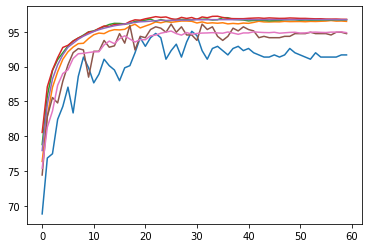

In [4]:
# %matplotlib widget

lines = epoch_weight_diff('redundancy_check/v0/base_old_60', 'redundancy_check/v0/student_old_60')

for line in lines:
    plt.plot(line)
plt.show()

In [5]:
m1 = tf.keras.models.load_model('redundancy_check/v1/v1_teacher_old_60')
m2 = tf.keras.models.load_model('redundancy_check/v1/v1_student_old_60')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 306 / 324 (94.44444444444444%)
Maximum Difference in Layer 1: 0.924899
Amount of different weights in Layer 2: 11181 / 11664 (95.85905349794238%)
Maximum Difference in Layer 2: 1.169397
Amount of different weights in Layer 3: 11129 / 11664 (95.41323731138546%)
Maximum Difference in Layer 3: 1.4686886
Amount of different weights in Layer 4: 11275 / 11664 (96.66495198902606%)
Maximum Difference in Layer 4: 1.5375421
Amount of different weights in Layer 5: 11362 / 11664 (97.41083676268862%)
Maximum Difference in Layer 5: 1.5207713
Amount of different weights in Layer 6: 11397 / 11664 (97.71090534979425%)
Maximum Difference in Layer 6: 0.9279548
Amount of different weights in Layer 7: 161570 / 165888 (97.3970389660494%)
Maximum Difference in Layer 7: 1.8521359
Amount of different weights in Layer 8: 490 / 512 (95.703125%)
Maximum Difference in Layer 8: 0.57765865
Amount of different weights in Layer 9: 4932 / 5120 (96.328125%)
Maximum Difference in L

[0.02546452358365059, 0.9958999752998352]

## Mnist model A with an extra Conv2D layer Self-Distillation trained with ReduceLROnPlateau

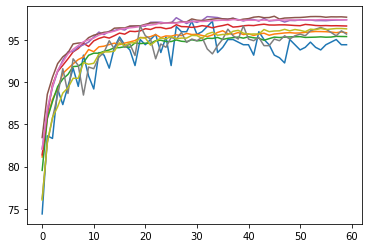

In [6]:
# %matplotlib widget

lines = epoch_weight_diff('redundancy_check/v1/v1_teacher_old_60', 'redundancy_check/v1/v1_student_old_60')

for line in lines:
    plt.plot(line)
plt.show()

In [7]:
m1 = tf.keras.models.load_model('redundancy_check/v2/v2_teacher_old_60')
m2 = tf.keras.models.load_model('redundancy_check/v2/v2_student_old_60')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 57 / 324 (17.59259259259259%)
Maximum Difference in Layer 1: 0.027243175
Amount of different weights in Layer 2: 3657 / 11664 (31.352880658436217%)
Maximum Difference in Layer 2: 0.08973491
Amount of different weights in Layer 3: 3433 / 11664 (29.432441700960222%)
Maximum Difference in Layer 3: 0.018975895
Amount of different weights in Layer 4: 3897 / 11664 (33.410493827160494%)
Maximum Difference in Layer 4: 0.0944793
Amount of different weights in Layer 5: 4487 / 11664 (38.468792866941016%)
Maximum Difference in Layer 5: 0.08519952
Amount of different weights in Layer 6: 5702 / 11664 (48.88545953360769%)
Maximum Difference in Layer 6: 0.08907693
Amount of different weights in Layer 7: 82180 / 165888 (49.53944830246913%)
Maximum Difference in Layer 7: 0.07275871
Amount of different weights in Layer 8: 165 / 512 (32.2265625%)
Maximum Difference in Layer 8: 0.024882078
Amount of different weights in Layer 9: 2261 / 5120 (44.16015625%)
Maximum Dif

[0.018657786771655083, 0.9940999746322632]

## Mnist model A with extra Conv2D layer Self-Distillation trained with LearningRateScheduler

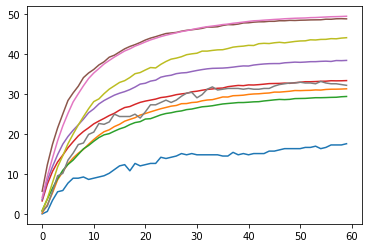

In [8]:
# %matplotlib widget

lines = epoch_weight_diff('redundancy_check/v2/v2_teacher_old_60', 'redundancy_check/v2/v2_student_old_60')

for line in lines:
    plt.plot(line)
plt.show()

In [9]:
m1 = tf.keras.models.load_model('new_model/v1/v1_teacher_old_60')
m2 = tf.keras.models.load_model('new_model/v1/v1_student_old_60')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 263 / 288 (91.31944444444444%)
Maximum Difference in Layer 1: 0.5270013
Amount of different weights in Layer 2: 30 / 32 (93.75%)
Maximum Difference in Layer 2: 0.41574627
Amount of different weights in Layer 3: 8735 / 9216 (94.78081597222221%)
Maximum Difference in Layer 3: 0.7891418
Amount of different weights in Layer 4: 31 / 32 (96.875%)
Maximum Difference in Layer 4: 0.654193
Amount of different weights in Layer 5: 24504 / 25600 (95.71875%)
Maximum Difference in Layer 5: 0.82350403
Amount of different weights in Layer 6: 31 / 32 (96.875%)
Maximum Difference in Layer 6: 0.22336972
Amount of different weights in Layer 7: 17740 / 18432 (96.24565972222221%)
Maximum Difference in Layer 7: 0.79646343
Amount of different weights in Layer 8: 62 / 64 (96.875%)
Maximum Difference in Layer 8: 0.46779442
Amount of different weights in Layer 9: 35302 / 36864 (95.76280381944444%)
Maximum Difference in Layer 9: 0.82203484
Amount of different weights in Laye

[0.02022099681198597, 0.9965999722480774]

## Mnist model B layer Self-Distillation trained with ReduceLROnPlateau

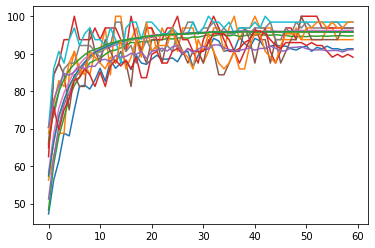

In [4]:
# %matplotlib widget

lines = epoch_weight_diff('new_model/v1/v1_teacher_old_60', 'new_model/v1/v1_student_old_60')

for line in lines:
    plt.plot(line)
plt.show()

In [3]:
m1 = tf.keras.models.load_model('new_model/v0/v0_teacher_new_60')
m2 = tf.keras.models.load_model('new_model/v0/v0_student_new_60')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 10 / 288 (3.4722222222222223%)
Maximum Difference in Layer 1: 0.012427985
Amount of different weights in Layer 2: 1 / 32 (3.125%)
Maximum Difference in Layer 2: 0.013044596
Amount of different weights in Layer 3: 688 / 9216 (7.465277777777778%)
Maximum Difference in Layer 3: 0.035996184
Amount of different weights in Layer 4: 0 / 32 (0.0%)
Maximum Difference in Layer 4: 0
Amount of different weights in Layer 5: 1272 / 25600 (4.96875%)
Maximum Difference in Layer 5: 0.025995564
Amount of different weights in Layer 6: 1 / 32 (3.125%)
Maximum Difference in Layer 6: 0.011638701
Amount of different weights in Layer 7: 3303 / 18432 (17.919921875%)
Maximum Difference in Layer 7: 0.02351069
Amount of different weights in Layer 8: 19 / 64 (29.6875%)
Maximum Difference in Layer 8: 0.014470518
Amount of different weights in Layer 9: 4700 / 36864 (12.749565972222221%)
Maximum Difference in Layer 9: 0.029955119
Amount of different weights in Layer 10: 8 / 64 

[0.01636120304465294, 0.9945999979972839]

## Mnist model B layer Self-Distillation trained with LearningRateScheduler

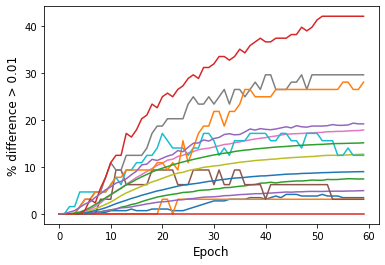

In [5]:
# %matplotlib widget

lines = epoch_weight_diff('new_model/v0/v0_teacher_new_60', 'new_model/v0/v0_student_new_60')

fig = plt.figure()
for line in lines:
    plt.plot(line)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('% difference > 0.01', fontsize=12)
    
plt.show()

fig.savefig("mnist_v0_60_comp.jpg", bbox_inches='tight', dpi=300)

In [7]:
m1 = tf.keras.models.load_model('new_model/v2/v2_teacher_new_90')
m2 = tf.keras.models.load_model('new_model/v2/v2_student_new_90')
weights_diff(m1, m2)

m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

Amount of different weights in Layer 1: 0 / 288 (0.0%)
Maximum Difference in Layer 1: 0
Amount of different weights in Layer 2: 0 / 32 (0.0%)
Maximum Difference in Layer 2: 0
Amount of different weights in Layer 3: 0 / 9216 (0.0%)
Maximum Difference in Layer 3: 0
Amount of different weights in Layer 4: 0 / 32 (0.0%)
Maximum Difference in Layer 4: 0
Amount of different weights in Layer 5: 0 / 25600 (0.0%)
Maximum Difference in Layer 5: 0
Amount of different weights in Layer 6: 0 / 32 (0.0%)
Maximum Difference in Layer 6: 0
Amount of different weights in Layer 7: 0 / 18432 (0.0%)
Maximum Difference in Layer 7: 0
Amount of different weights in Layer 8: 0 / 64 (0.0%)
Maximum Difference in Layer 8: 0
Amount of different weights in Layer 9: 0 / 36864 (0.0%)
Maximum Difference in Layer 9: 0
Amount of different weights in Layer 10: 0 / 64 (0.0%)
Maximum Difference in Layer 10: 0
Amount of different weights in Layer 11: 0 / 102400 (0.0%)
Maximum Difference in Layer 11: 0
Amount of different wei

[0.04275054484605789, 0.9853000044822693]

## Mnist model B layer Self-Distillation trained with LearningRateScheduler and 90 epochs

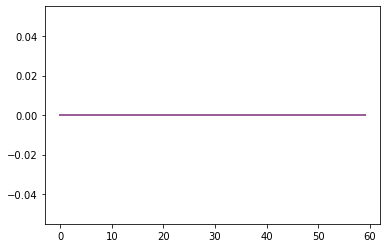

In [7]:
# %matplotlib widget

lines = epoch_weight_diff('new_model/v2/v2_teacher_new_90', 'new_model/v2/v2_student_new_90')

for line in lines:
    plt.plot(line)
plt.show()

In [8]:
m1 = tf.keras.models.load_model('new_model/v2/v2_teacher_new_90-01')
m2 = tf.keras.models.load_model('new_model/v2/v2_student_new_90-01')
m1.layers[1].get_weights()[0]

array([1.0005457 , 1.0005746 , 1.000022  , 0.99965256, 0.9999406 ,
       1.000231  , 0.9989253 , 1.0004662 , 0.99973905, 1.0006468 ,
       0.9995219 , 0.999264  , 1.0004407 , 1.0007771 , 1.0002397 ,
       1.0006833 , 1.0001408 , 0.99856246, 0.99882245, 1.0013385 ,
       1.0007441 , 0.9987658 , 1.0004623 , 0.9990053 , 0.9997853 ,
       1.0004537 , 0.9987236 , 0.9998182 , 0.999798  , 0.999903  ,
       0.99916005, 1.0008368 ], dtype=float32)

In [9]:
m1 = tf.keras.models.load_model('new_model/v2/v2_teacher_new_90-50')
m2 = tf.keras.models.load_model('new_model/v2/v2_student_new_90-50')
m1.layers[1].get_weights()[0]

array([1.01388   , 1.0173744 , 0.99439436, 0.9895311 , 0.99941295,
       1.0016474 , 0.9808729 , 1.0035157 , 0.9938404 , 0.99454755,
       1.0065145 , 1.0053196 , 1.0028527 , 0.9931795 , 1.0042446 ,
       1.0046928 , 1.0001746 , 0.99104697, 0.98934114, 1.0053651 ,
       0.995314  , 0.99076957, 0.9978673 , 0.9908145 , 0.997582  ,
       1.0016735 , 0.9983986 , 1.0024908 , 1.0003909 , 0.99845684,
       0.99454445, 1.0055102 ], dtype=float32)